In [1]:
%load_ext autoreload
%autoreload 2
from config import *
from musegan import MuseGAN
from data_utils import prepare_training_data
from tqdm.notebook import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from train import create_directories, plot_training_history
from musegan import MuseGAN
from data_utils import prepare_training_data

In [2]:
# Load the data
file = os.path.join("/content/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

In [3]:
N_SONGS = len(data)
print(f"{N_SONGS} chorales in the dataset")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"{N_BEATS, N_TRACKS} shape of chorale 0")
print("\nChorale 0")
print(chorale[:8])

229 chorales in the dataset
(192, 4) shape of chorale 0

Chorale 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]


In [4]:
two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data]) # Collect two bars
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"Two bars shape {two_bars.shape}")

Two bars shape (229, 2, 16, 4)


In [5]:
data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"Data binary shape {data_binary.shape}")

Data binary shape (229, 2, 16, 84, 4)


In [6]:
create_directories()

In [7]:
dataloader = prepare_training_data()

Loading Bach chorales data...
229 chorales loaded from dataset
Sample chorale shape: (192, 4) (beats: 192, tracks: 4)

First 8 steps of chorale 0:
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]
Preprocessing data...
Two bars shape: (229, 2, 16, 4)
Data binary shape: (229, 2, 16, 84, 4)
Data range: [-1.0, 1.0]
Creating DataLoader...
Created tensor with shape: torch.Size([229, 2, 16, 84, 4])
DataLoader created with 3 batches
Data preparation complete!


In [8]:
musegan = MuseGAN()

In [9]:
history = musegan.training_history
for epoch in range(1000):
    epoch_losses = {'c_loss': 0, 'c_wass_loss': 0, 'c_gp': 0, 'g_loss': 0}
    for batch_idx, (real_batch,) in enumerate(dataloader):
        real_batch = real_batch.to(DEVICE)
        losses = musegan.train_step(real_batch)
        for k, v in losses.items():
            epoch_losses[k] += v

    if (epoch + 1) % 10 == 0:
        avg_losses = {k: v / len(dataloader) for k, v in epoch_losses.items()}
        print(f"Epoch {(epoch+1):04d} Average losses -> {avg_losses}", flush=True)


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0010 Average losses -> {'c_loss': -127.46371663411458, 'c_wass_loss': -201.9373992919922, 'c_gp': 7.447368351618448, 'g_loss': -81.68905131022136}
Epoch 0020 Average losses -> {'c_loss': -66.96426645914714, 'c_wass_loss': -98.88049570719402, 'c_gp': 3.191622956593831, 'g_loss': 78.28994115193684}
Epoch 0030 Average losses -> {'c_loss': -18.774654642740884, 'c_wass_loss': -24.819003423055012, 'c_gp': 0.6044349017708252, 'g_loss': -185.07209014892578}
Epoch 0040 Average losses -> {'c_loss': -13.433967018127442, 'c_wass_loss': -16.62753588358561, 'c_gp': 0.31935687984029454, 'g_loss': 46.56798521677653}
Epoch 0050 Average losses -> {'c_loss': -15.437911860148112, 'c_wass_loss': -19.579692967732747, 'c_gp': 0.41417811289429657, 'g_loss': 3.44879150390625}
Epoch 0060 Average losses -> {'c_loss': -14.307752736409505, 'c_wass_loss': -17.868160057067872, 'c_gp': 0.3560407479604086, 'g_loss': -26.023059844970703}
Epoch 0070 Average losses -> {'c_loss': -12.135329627990723, 'c_wass_loss': 

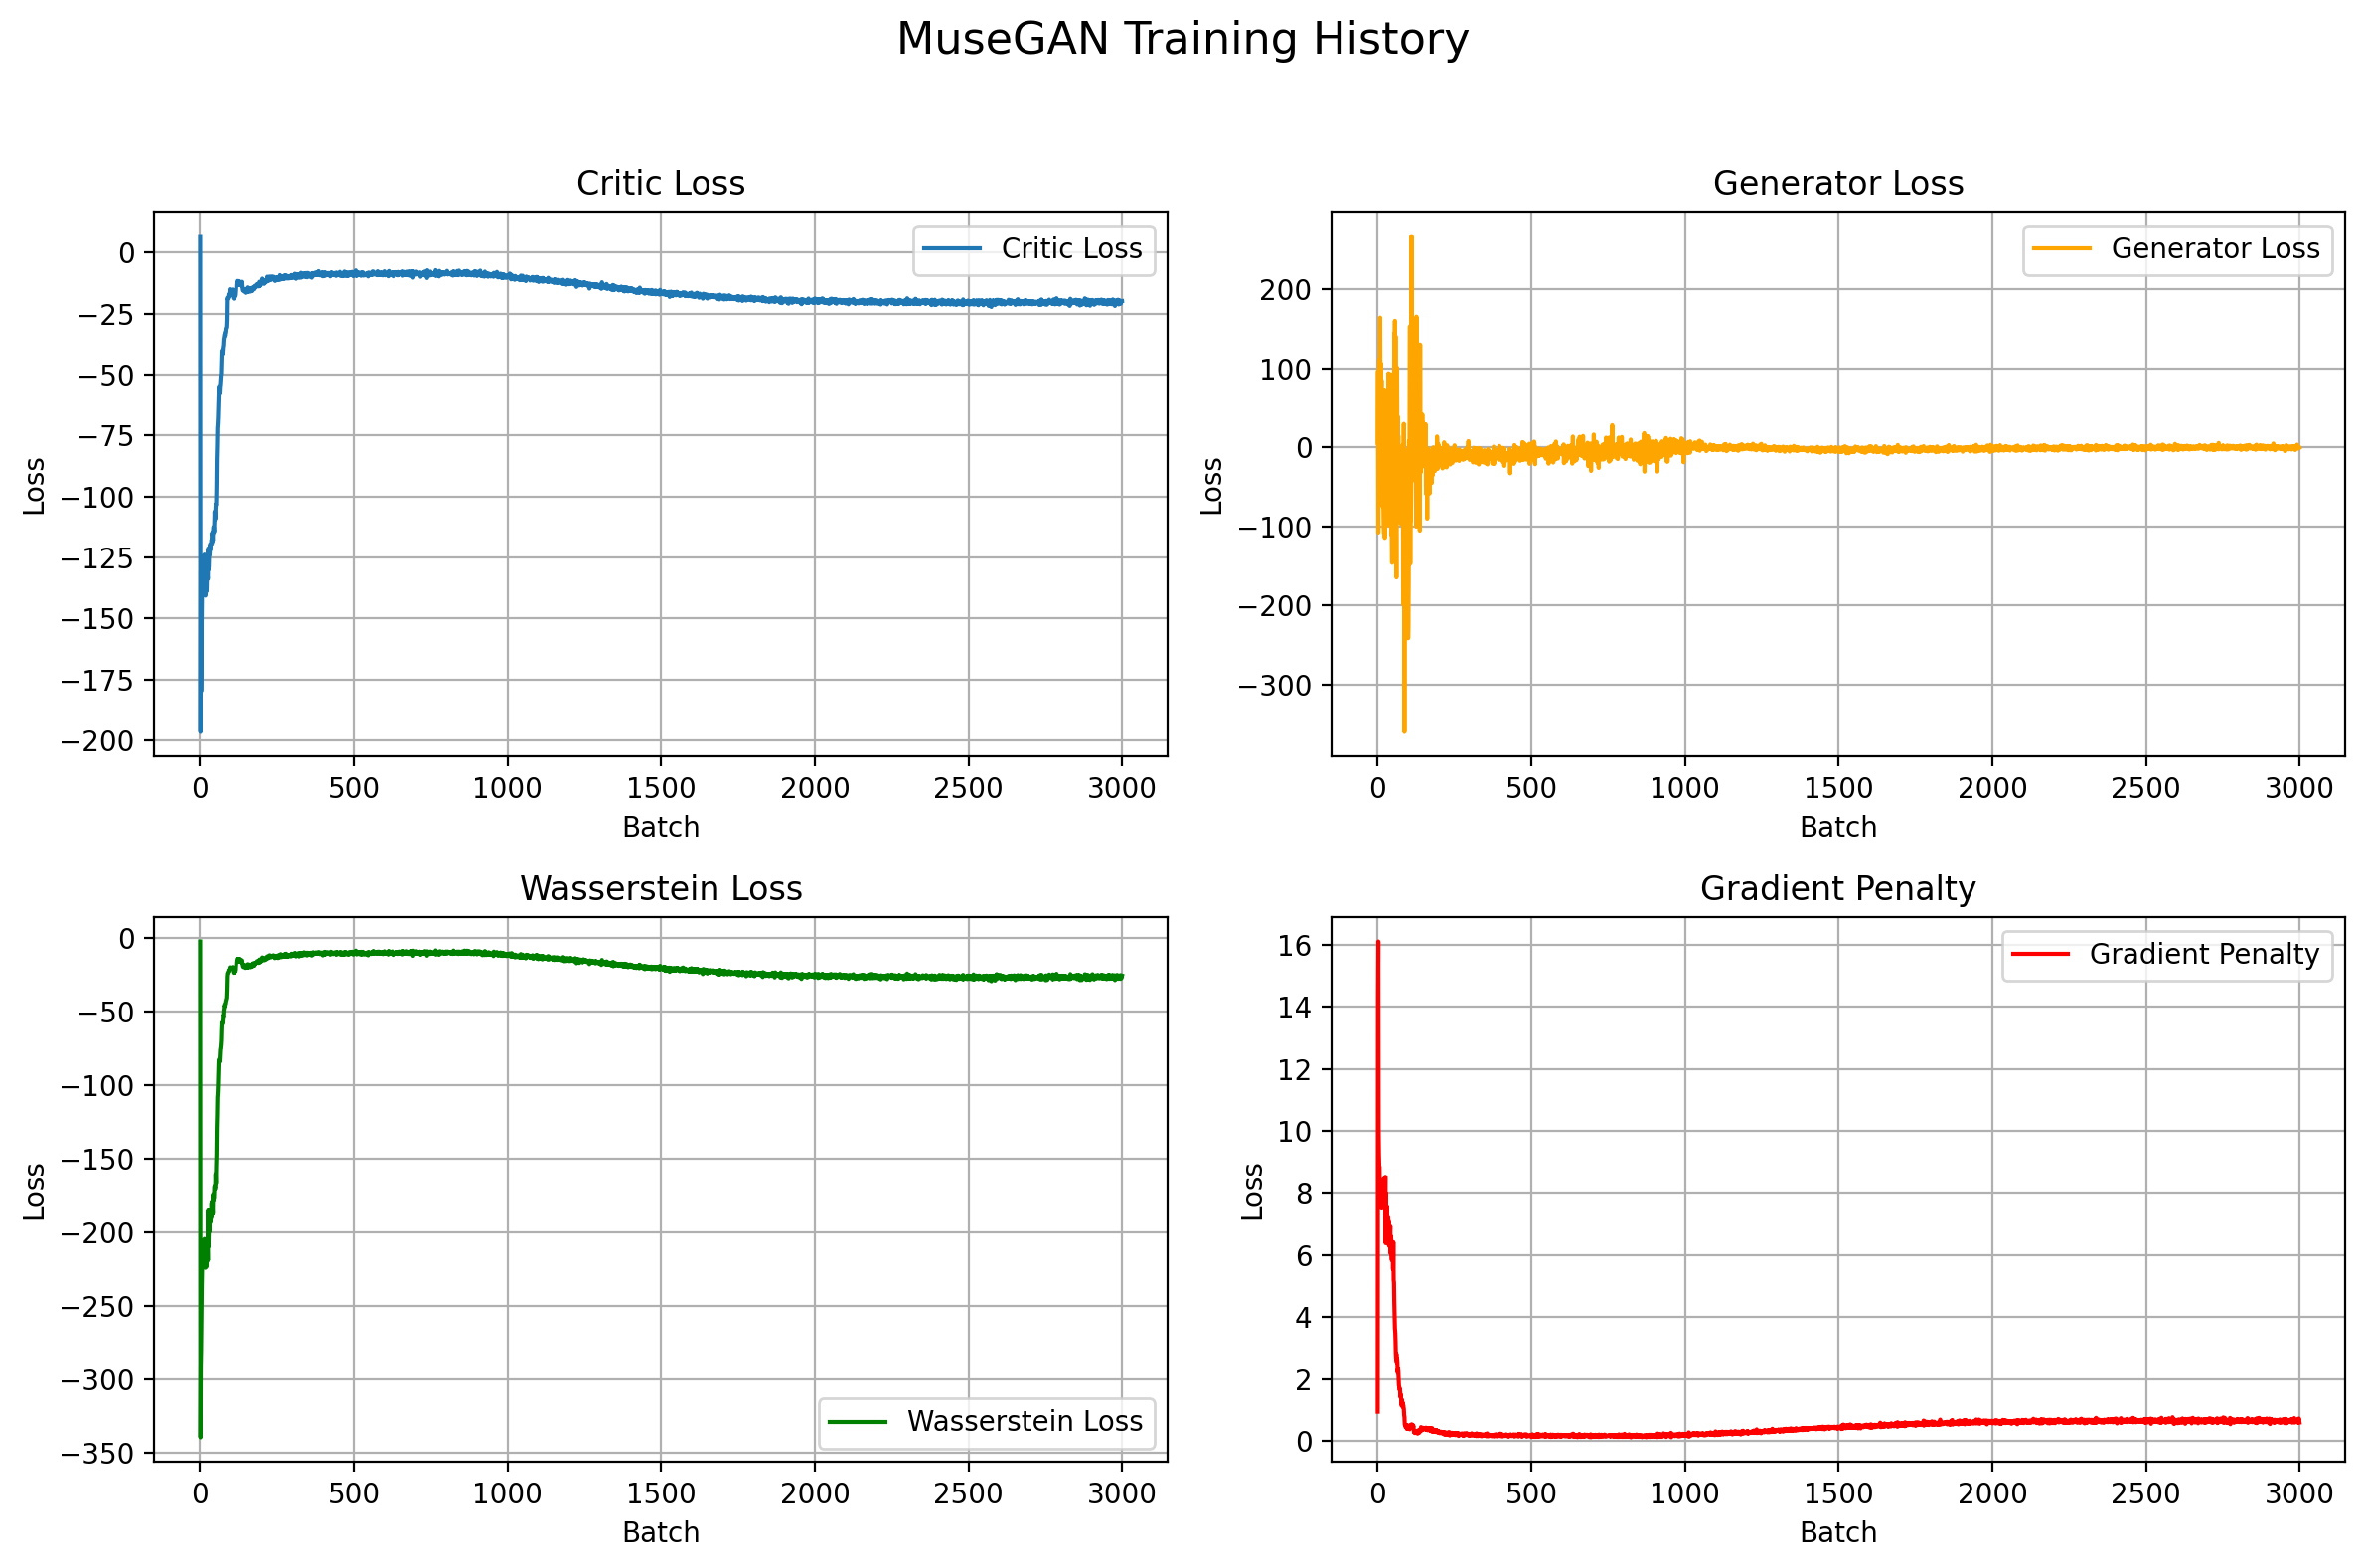

In [10]:
plot_training_history(history, save_path=os.path.join(LOGS_DIR, "training_history.png"))

In [11]:
from config import Z_DIM, N_TRACKS, N_BARS, N_STEPS_PER_BAR

In [12]:
musegan.generator.eval()

Generator(
  (chords_temp_network): TemporalNetwork(
    (conv1): Sequential(
      (0): ConvTranspose2d(32, 1024, kernel_size=(2, 1), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): ConvTranspose2d(1024, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (melody_temp_networks): ModuleList(
    (0-3): 4 x TemporalNetwork(
      (conv1): Sequential(
        (0): ConvTranspose2d(32, 1024, kernel_size=(2, 1), stride=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): ConvTranspose2d(1024, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [13]:
device = musegan.device

In [14]:
def sample_and_save(latents, filename, idx=0):
    """Helper: run generator, convert to cpu-numpy, draw & save MIDI."""
    # stack & to‐tensor
    inputs = [torch.from_numpy(z).float().to(device) for z in latents]
    with torch.no_grad():
        out = musegan.generator(inputs)         # [batch, bars, steps, pitches, tracks]
    out = out.cpu().numpy()
    draw_score(out, idx)
    notes_to_midi(out, N_BARS, N_TRACKS, N_STEPS_PER_BAR, filename=filename)

# Original random sample


In [15]:
# 1) Original random sample
num_scores = 1
chords_z = np.random.randn(num_scores, Z_DIM)
style_z  = np.random.randn(num_scores, Z_DIM)
melody_z = np.random.randn(num_scores, N_TRACKS, Z_DIM)
groove_z = np.random.randn(num_scores, N_TRACKS, Z_DIM)

In [19]:
from musegan_utils import draw_score, notes_to_midi

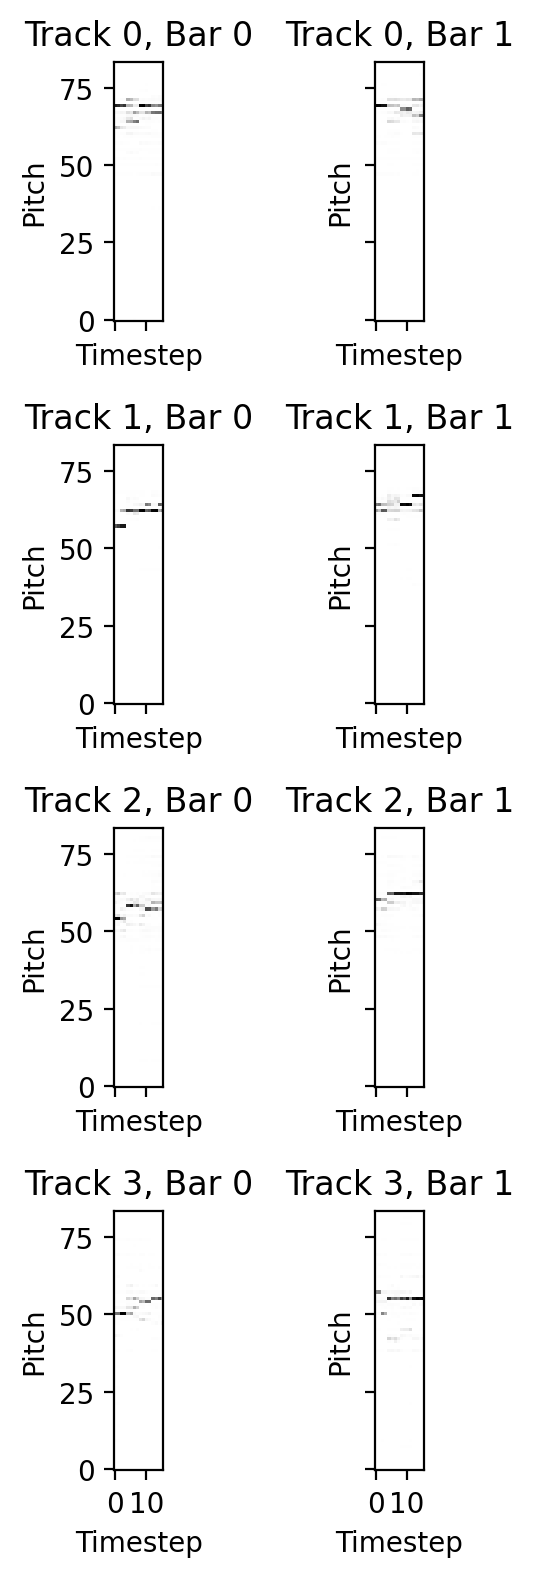

In [20]:

sample_and_save(
    [chords_z, style_z, melody_z, groove_z],
    filename="output_midi"
)


# 2) Change only the chord noise

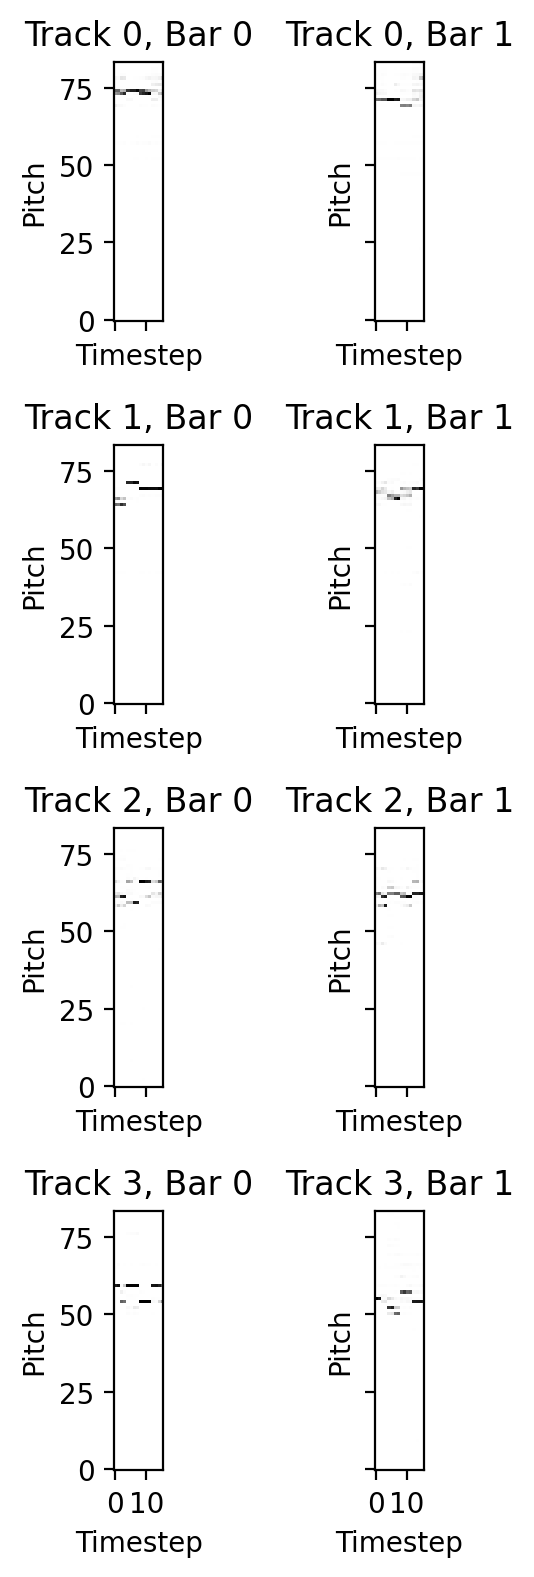

In [21]:
chords_z2 = np.random.randn(num_scores, Z_DIM)
sample_and_save(
    [chords_z2, style_z, melody_z, groove_z],
    filename="output_midi_chords_changed"
)


# 3) Change only the style noise

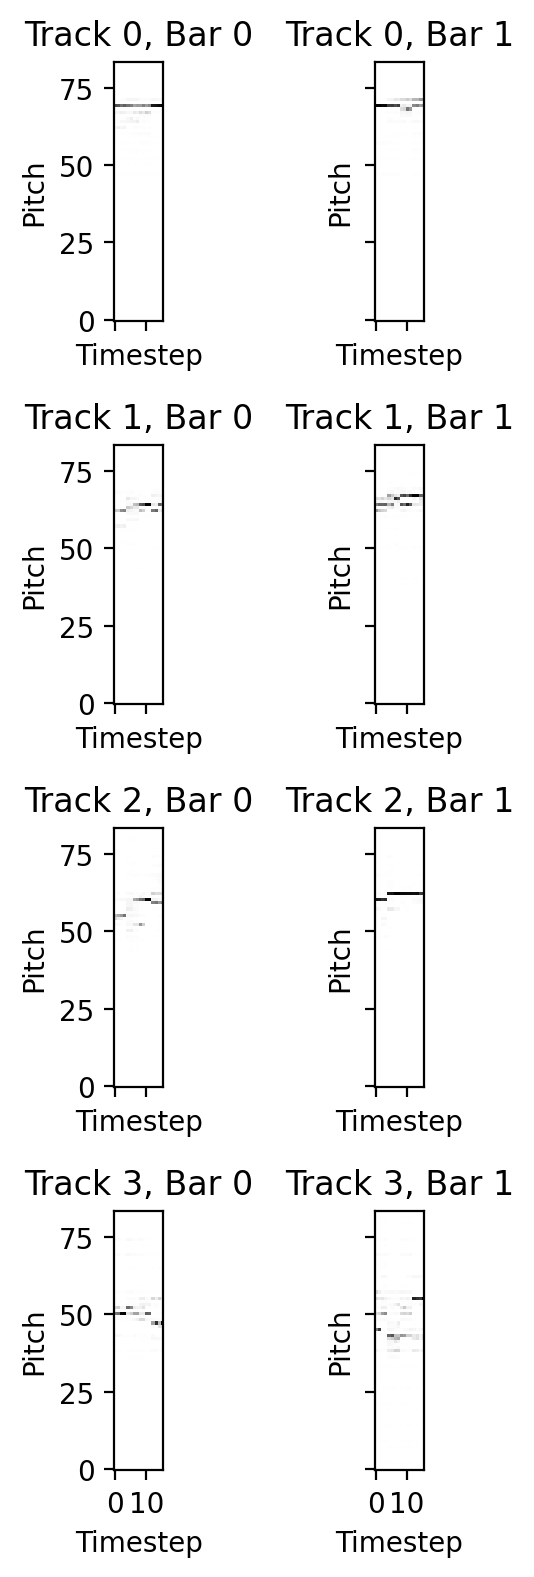

In [22]:
style_z2 = np.random.randn(num_scores, Z_DIM)
sample_and_save(
    [chords_z, style_z2, melody_z, groove_z],
    filename="output_midi_style_changed"
)

# 4) Change only the first-track melody noise

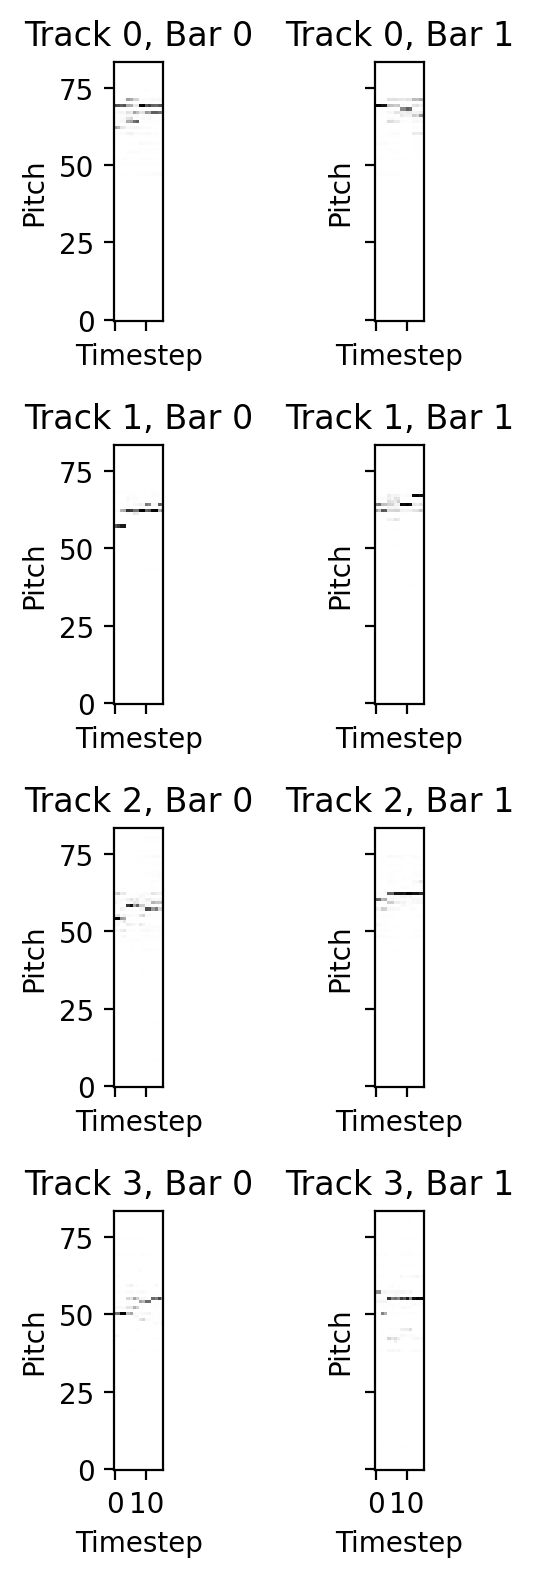

In [23]:
melody_z2 = melody_z.copy()
melody_z2[:, 0, :] = np.random.randn(num_scores, Z_DIM)
sample_and_save(
    [chords_z, style_z, melody_z2, groove_z],
    filename="output_midi_melody_changed"
)

# 5) Change only the last-track groove noise

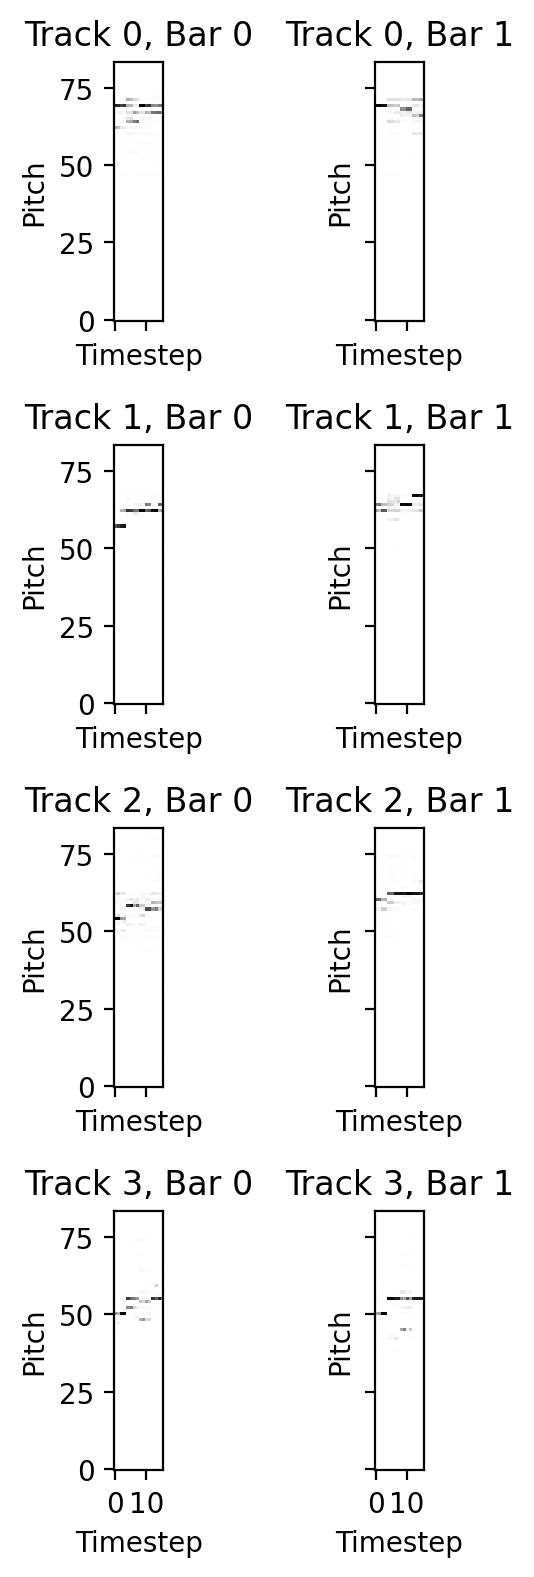

In [24]:
groove_z2 = groove_z.copy()
groove_z2[:, -1, :] = np.random.randn(num_scores, Z_DIM)
sample_and_save(
    [chords_z, style_z, melody_z, groove_z2],
    filename="output_midi_groove_changed"
)